In [1]:
import sys
sys.path.append('/Users/aidanmorrison/bayesnets')

In [19]:
from swarm import core
from swarm import io
import json
import basic_hive
import importlib
from matplotlib import pyplot as plt

In [3]:
importlib.reload(basic_hive)

<module 'basic_hive' from '/Users/aidanmorrison/bayesnets/experiments/goofy/basic_hive.py'>

In [34]:
reslist, static_params = basic_hive.main()

In [36]:
my_dict = reslist[0]

In [37]:
my_dict

{'results': {'ypred': array([[[ 0.5067997 ,  0.48141554,  0.4566283 , ..., -0.68168855,
           -0.71989   , -0.7584077 ],
          [ 0.50630534,  0.48093456,  0.4561603 , ..., -0.681381  ,
           -0.7195765 , -0.758088  ],
          [ 0.5054742 ,  0.4801249 ,  0.45537257, ..., -0.68086535,
           -0.71905065, -0.75755227],
          ...,
          [ 0.48261434,  0.4570974 ,  0.43220288, ..., -0.6734604 ,
           -0.71272826, -0.752311  ],
          [ 0.48266116,  0.4571167 ,  0.43219528, ..., -0.67372024,
           -0.713035  , -0.7526647 ],
          [ 0.48271558,  0.45714334,  0.43219504, ..., -0.6739855 ,
           -0.71334743, -0.75302446]],
  
         [[-0.3222792 , -0.31145537, -0.30093658, ...,  0.16685912,
            0.17750674,  0.1882756 ],
          [-0.29538012, -0.2856763 , -0.27627718, ...,  0.14589605,
            0.15542924,  0.16508242],
          [-0.25043964, -0.24260706, -0.23507851, ...,  0.11089036,
            0.1185618 ,  0.12635121],
       

In [6]:
my_df = io.to_2d(my_dict['results']['ypred'], "ypred")

In [27]:
static_params = {'a':1, 'b':2.2}

In [33]:
destdir = '..'
with open("static_params.json", "w") as f:
        json.dump(static_params, f)

In [7]:
my_df.reset_index()


,bee,epoch,ypred,ypred_val
0,0,0,0,0.506800
1,0,0,1,0.481416
2,0,0,2,0.456628
3,0,0,3,0.432458
4,0,0,4,0.408923
...,...,...,...,...
12195,3,49,56,-0.654234
12196,3,49,57,-0.680392
12197,3,49,58,-0.706446
12198,3,49,59,-0.732398


In [30]:
static_params['x'] = list(static_params['x'])
static_params['y'] = list(static_params['y'])

In [32]:
static_params['x'] = [str(a) for a in static_params['x']]
static_params['y'] = [str(a) for a in static_params['y']]
static_params['seed'] = str(static_params['seed'])

In [35]:
static_params

{'x': array([-5.        , -4.8333335 , -4.6666665 , -4.5       , -4.3333335 ,
        -4.1666665 , -4.        , -3.8333333 , -3.6666667 , -3.5       ,
        -3.3333333 , -3.1666667 , -3.        , -2.8333333 , -2.6666667 ,
        -2.5       , -2.3333333 , -2.1666667 , -2.        , -1.8333334 ,
        -1.6666666 , -1.5       , -1.3333334 , -1.1666666 , -1.        ,
        -0.8333333 , -0.6666667 , -0.5       , -0.33333334, -0.16666667,
         0.        ,  0.16666667,  0.33333334,  0.5       ,  0.6666667 ,
         0.8333333 ,  1.        ,  1.1666666 ,  1.3333334 ,  1.5       ,
         1.6666666 ,  1.8333334 ,  2.        ,  2.1666667 ,  2.3333333 ,
         2.5       ,  2.6666667 ,  2.8333333 ,  3.        ,  3.1666667 ,
         3.3333333 ,  3.5       ,  3.6666667 ,  3.8333333 ,  4.        ,
         4.1666665 ,  4.3333335 ,  4.5       ,  4.6666665 ,  4.8333335 ,
         5.        ], dtype=float32),
 'y': array([ 0.9589243 ,  0.9926951 ,  0.9989549 ,  0.9775301 ,  0.92901456,
   

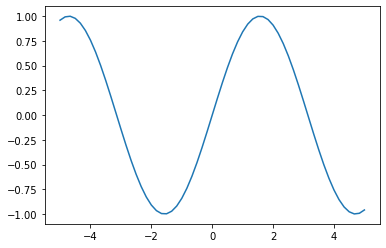

In [12]:
plt.plot(static_params['x'], static_params['y'])